In [1]:
# 参考链接 https://blog.csdn.net/u010866505/article/details/77877345

In [168]:
import random
import copy
import numpy as np
from scipy.stats import multivariate_normal
from sklearn import mixture, metrics
# from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pylab as plt
from IPython.core.interactiveshell import InteractiveShell


In [160]:
# 配置项
# 这个要放到设置中文之前否则还是小方框
plt.style.use("seaborn")

# 指定默认字体 用来正常显示中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

# #全部行都能输出
InteractiveShell.ast_node_interactivity = "all"

In [170]:
%config IPCompleter.greedy=True


In [107]:
np.random.seed(0)
# 均值
mu1_fact = (0, 0, 0)
# 协方差 因为只有对角线上是1 可以认为特征之间是相互独立的
cov_fact = np.identity(3)
data1 = np.random.multivariate_normal(mu1_fact, cov_fact, 400)

mu2_fact = (2, 2, 1)
data2 = np.random.multivariate_normal(mu2_fact, cov_fact, 100)
data = np.vstack((data1, data2))
# y 标记数据来自哪一个
y = np.array([True] * 400 + [False] * 100)
data[:10]
data.shape
y[::50]

array([[ 1.76405235,  0.40015721,  0.97873798],
       [ 2.2408932 ,  1.86755799, -0.97727788],
       [ 0.95008842, -0.15135721, -0.10321885],
       [ 0.4105985 ,  0.14404357,  1.45427351],
       [ 0.76103773,  0.12167502,  0.44386323],
       [ 0.33367433,  1.49407907, -0.20515826],
       [ 0.3130677 , -0.85409574, -2.55298982],
       [ 0.6536186 ,  0.8644362 , -0.74216502],
       [ 2.26975462, -1.45436567,  0.04575852],
       [-0.18718385,  1.53277921,  1.46935877]])

(500, 3)

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False])

In [119]:
# 高斯混合模型 作为验证模型
model = mixture.GaussianMixture(n_components=2, covariance_type='full', max_iter=1000)
model.fit(data)
print ('类别概率:\t', model.weights_[0])
print ('均值:\n', model.means_, '\n')
print ('方差:\n', model.covariances_, '\n')

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=1000,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

类别概率:	 0.7338362795170915
均值:
 [[-0.0867986  -0.07944592 -0.13074371]
 [ 1.71563515  1.72278426  0.90711776]] 

方差:
 [[[ 0.84393957 -0.10727031 -0.0292304 ]
  [-0.10727031  1.00733576 -0.10130537]
  [-0.0292304  -0.10130537  0.85333245]]

 [[ 1.13520137  0.07550074  0.00520928]
  [ 0.07550074  1.16634832  0.08100695]
  [ 0.00520928  0.08100695  0.89846354]]] 



In [94]:
a = np.array([1, 2, 3])
b = np.array([2, 3, 4])
c = np.array([0, -2, 9])

x = np.vstack((a,b, c))
x
x.min(axis=0)

array([[ 1,  2,  3],
       [ 2,  3,  4],
       [ 0, -2,  9]])

array([ 0, -2,  3])

In [156]:
def my_EM(data):
    # k个高斯混合而成
    k = 2
    # n 为样本数量 d为数据的维度
    n, d = data.shape
    # 取出每一列的最小值作为初始的均值
    mu1 = data.min(axis=0)
    # 取出每一列最大的值作为初始的均值
    mu2 = data.max(axis=0)
    
    # 初始化标准差
    sigma1 = np.identity(d)
    sigma2 = np.identity(d)
    
    # 初始化第一个高斯分布的权重p为0.5, 另外一个高斯分布的权重则为1-p
    pi = 0.5
    # 初始化最大迭代次数
    max_iter = 100
    for num_iter in range(max_iter):
        # E Step
        # 将初始化后的mu1, mu2(均值), sigma1, sigma2(方差)
        norm1 = multivariate_normal(mu1, sigma1)
        norm2 = multivariate_normal(mu2, sigma2)
        # 把data里面的数据带入到norm1正态分布得出的值 tau1 (500,)
        tau1 = norm1.pdf(data)
        # pi是第一个高斯分布所占的权重,乘以tau1原始数据中第一个高斯分布的组成部分
        tau1 = pi * tau1
        # 原始数据中第二个高斯分布的组成部分
        tau2 = (1 - pi) * norm2.pdf(data)  
        gamma = tau1 / (tau1 + tau2)
        
        # M Step
        # 更新均值和标准差
        mu1 = np.dot(gamma, data) / np.sum(gamma)
        mu2 = np.dot((1- gamma), data) / np.sum((1-gamma))
        
        sigma1 = np.dot(gamma * (data - mu1).T, data-mu1) / np.sum(gamma)
        sigma2 = np.dot((1-gamma) * (data - mu2).T, data - mu2) / np.sum(1 - gamma)
        pi = np.sum(gamma) / n
        
        print (num_iter, ":\t", mu1, mu2)
    print('类别概率:\t', pi)
    print ('均值:\t', mu1, mu2)
    print ('方差:\n', sigma1, '\n\n', sigma2, '\n')
    return mu1, mu2, sigma1, sigma2



In [157]:
mu1, mu2, sigma1, sigma2= my_EM(data)

0 :	 [-0.11359772 -0.11177414 -0.15582682] [1.750978   1.77295469 0.95334518]
1 :	 [-0.0939775  -0.08867467 -0.1415379 ] [1.73674934 1.74955546 0.93765719]
2 :	 [-0.08563433 -0.07998234 -0.13520388] [1.73113767 1.74304012 0.93039031]
3 :	 [-0.08160252 -0.07623707 -0.13193519] [1.72907607 1.74181727 0.9266361 ]
4 :	 [-0.07948608 -0.07449048 -0.13007819] [1.72868927 1.74249895 0.92465788]
5 :	 [-0.07827794 -0.07359204 -0.1289329 ] [1.72913547 1.74384222 0.92366889]
6 :	 [-0.0775152  -0.07305603 -0.12816899] [1.72999799 1.74536591 0.92326261]
7 :	 [-0.0769756  -0.07267274 -0.1276201 ] [1.7310608  1.74688951 0.92321165]
8 :	 [-0.07655    -0.07235237 -0.12719832] [1.73220969 1.74835366 0.92338186]
9 :	 [-0.07618418 -0.07205768 -0.12685529] [1.73338411 1.74974598 0.92369098]
10 :	 [-0.07585108 -0.07177418 -0.12656335] [1.73455232 1.75107047 0.92408711]
11 :	 [-0.07553725 -0.07149693 -0.12630607] [1.7356982  1.75233526 0.92453671]
12 :	 [-0.07523601 -0.07122473 -0.12607335] [1.73681408 1.7535

Text(0.5, 0, 'X')

Text(0.5, 0.92, '原始数据')

准确率：91.00%


Text(0.5, 0, 'X')

Text(0.5, 0, 'Y')

Text(0.5, 0, 'Z')

Text(0.5, 0.92, 'EM算法分类')

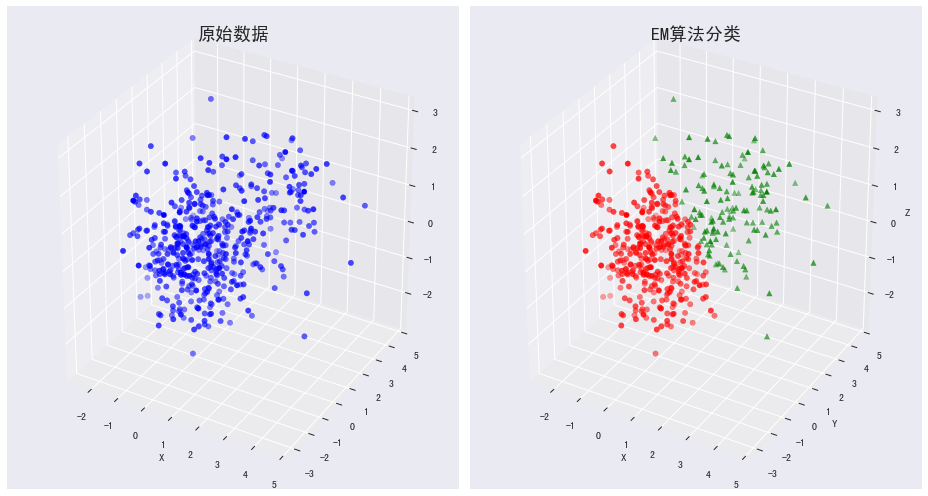

In [169]:
# 预测分类
norm1 = multivariate_normal(mu1, sigma1)
norm2 = multivariate_normal(mu2, sigma2)
tau1 = norm1.pdf(data)
tau2 = norm2.pdf(data)

fig = plt.figure(figsize=(13, 7))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='b', s=30, marker='o', depthshade=True)
ax.set_xlabel('X')
ax.set_label('Y')
ax.set_label('Z')
ax.set_title('原始数据', fontsize=18)

ax = fig.add_subplot(122, projection='3d')
order = metrics.pairwise.pairwise_distances_argmin([mu1_fact, mu2_fact], [mu1, mu2])
if order[0] == 0:
    c1 = tau1 > tau2
else:
    c1 = tau1 < tau2
c2 = ~c1
acc = np.mean(y == c1)
print ('准确率：%.2f%%' % (100*acc))
ax.scatter(data[c1, 0], data[c1, 1], data[c1, 2], c='r', s=30, marker='o', depthshade=True)
ax.scatter(data[c2, 0], data[c2, 1], data[c2, 2], c='g', s=30, marker='^', depthshade=True)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('EM算法分类', fontsize=18)
plt.tight_layout()
plt.show()

In [172]:
metrics.pairwise.pairwise_distances_argmin([mu1_fact, mu2_fact], [mu1, mu2])

array([0, 1])